In [0]:
# APPENDIX C: FEATURE ENGINEERING AND MODELING CODE

# Data Cleaning Code.
# Install the necessary functions.

%pip install textblob
%pip install s3fs

In [0]:
# Import the necessary functions.
from pyspark.sql.functions import col, isnan, when, count, udf import pandas as pd
import seaborn as sns
import matplotlib as mpl
import sklearn
import numpy
import scipy
import plotly
import bs4 as bs
import urllib.request
import boto3

In [0]:
import os
# To work with Amazon S3 storage, set the following variables using AWS Access Key and Secret Key.
# Set the Region to where the files are stored in S3.
access_key = '_____'
secret_key = '_____'
# Set the environment variables so boto3 can pick them up later.
os.environ['AWS_ACCESS_KEY_ID'] = access_key
os.environ['AWS_SECRET_ACCESS_KEY'] = secret_key
encoded_secret_key = secret_key.replace("/", "%2F")
aws_region = "us-east-2"

# Update the Spark options to work with AWS Credentials.
sc._jsc.hadoopConfiguration().set("fs.s3a.access.key", access_key)
sc._jsc.hadoopConfiguration().set("fs.s3a.secret.key", secret_key)
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3." + aws_region + ".amazonaws.com")

In [0]:
# Import the necessary functions.
from pyspark.sql.functions import col, isnan, when, count, udf

# Set the Spark logging level to only show errors.
sc.setLogLevel("ERROR")

# Set up the path to an Amazon reviews data stored on S3.
bucket = 'my-bigdata-project-sf/landing/'
filename = 'amazon_reviews_us_Gift_Card_v1_00.tsv'
file_path = 's3a://' + bucket + filename

# Create a Spark Dataframe from the file on S3.
sdf = spark.read.csv(file_path, sep='\t', header=True, inferSchema=True)

In [0]:
# Check the schema.
sdf.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: string (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: date (nullable = true)



In [0]:
# Get the number of records in the dataframe.
sdf.count()

Out[49]: 96901

In [0]:
# Get some statistics on each of the columns.
sdf.summary("count", "min", "max").show()

+-------+--------------------+----------------+------------------+------------------+-------------------+----+-----------------+---------------+--------------------+
|summary|       product_title|product_category|       star_rating|     helpful_votes|        total_votes|vine|verified_purchase|review_headline|         review_body|
+-------+--------------------+----------------+------------------+------------------+-------------------+----+-----------------+---------------+--------------------+
|  count|                9310|            9310|              9310|              9310|               9310|9310|             9310|           9310|                9310|
|   mean|                null|            null| 4.734586466165413|0.3684210526315789|0.45961331901181524|null|             null|           null|                 1.0|
| stddev|                null|            null|0.8157833912260218|10.006090721101005|  12.06941071929207|null|             null|           null|                null|
|   

In [0]:
# Check to see if any relevant columns have null values.
sdf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in ["product_title", "product_category", "star_rating", "helpful_votes", "total_votes", "vine", "verified_purchase", "review_headline", "review_body"]] ).show()

+-------------+----------------+-----------+-------------+-----------+----+-----------------+---------------+-----------+
|product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|review_headline|review_body|
+-------------+----------------+-----------+-------------+-----------+----+-----------------+---------------+-----------+
|            0|               0|          0|            0|          0|   0|                0|              0|          6|
+-------------+----------------+-----------+-------------+-----------+----+-----------------+---------------+-----------+



In [0]:
# Drop some of the records where the relevant columns are empty.
sdf = sdf.na.drop(subset=["product_title", "product_category", "star_rating", "helpful_votes", "total_votes", "vine", "verified_purchase", "review_headline", "review_body"])

In [0]:
# Define a function to strip out any non-ascii characters.
def ascii_only(mystring):
    if mystring:
        return mystring.encode('ascii', 'ignore').decode('ascii')
    else:
        return None

# Turn this function into a User-Defined Function (UDF).
ascii_udf = udf(ascii_only)

# Clean up the review_headline and review_body.
sdf = sdf.withColumn("clean_review_headline", ascii_udf('review_headline'))
sdf = sdf.withColumn("clean_review_body", ascii_udf('review_body'))

# Review the cleaned review_headline and review_body.
sdf.select("clean_review_headline", "clean_review_body").summary("count", "min", "max").show()

+-------+---------------------+--------------------+
|summary|clean_review_headline|   clean_review_body|
+-------+---------------------+--------------------+
|  count|              5114742|             5114742|
|    min|                     |                    |
|    max| ~~~~~DO~~~NOT~~~B...|~~~~~~~~~~~~~~~~~...|
+-------+---------------------+--------------------+



In [0]:
# Drop the columns that aren't relevant for feature engineering and modeling.
# Also drop review_headline and review_body, since the cleaned version will be used for feature engineering and modeling.
sdf = sdf.drop("marketplace", "customer_id", "review_id", "product_id", "product_parent", "review_date", "review_headline", "review_body")

In [0]:
# Check the schema now that null values are removed and irrelevant columns were dropped.
sdf.printSchema()

root
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: string (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- clean_review_headline: string (nullable = true)
 |-- clean_review_body: string (nullable = true)



In [0]:
# Check the number of records now that null values are removed and irrelevant columns were dropped.
sdf.count()

Out[56]: 96888

In [0]:
# Save the cleaned dataframe in raw folder of S3 bucket as a Parquet file.
output_file_path="s3://my-bigdata-project-sf/raw/cleaned_amazon_reviews_us_Gift_Card_v1_00.parquet"
sdf.write.parquet(output_file_path)

In [0]:
# Modeling Code.
# Import the necessary functions.
from pyspark.sql.functions import col, isnan, when, count, udf

# Set the Spark logging level to only show errors.
sc.setLogLevel("ERROR")

# Set up the path to an Amazon reviews data stored on S3.
bucket = 'my-bigdata-project-sf/raw/'
filename = 'cleaned_amazon_reviews_us_Gift_Card_v1_00.parquet'
file_path = 's3a://' + bucket + filename

# Create a Spark Dataframe from the file on S3.
sdf = spark.read.parquet(file_path, sep='\t', header=True, inferSchema=True)

In [0]:
#Take a 1% sample of the data.
sdf = sdf.sample(False, 0.01)

In [0]:
# Check the schema.
sdf.printSchema()

root
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- clean_review_headline: string (nullable = true)
 |-- clean_review_body: string (nullable = true)



In [0]:
# Tokenize clean_review_body, and then repeat process for clean_review_headline.
from pyspark.ml.feature import Tokenizer, RegexTokenizer

regexTokenizer = RegexTokenizer(inputCol="clean_review_body", outputCol="review_body_words", pattern="\\w+", gaps=False)
review_body_words_sdf = regexTokenizer.transform(sdf)

review_body_words_sdf.select("clean_review_body", "review_body_words").show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [0]:
# Generate the term-frequency for clean_review_body, and then repeat process for clean_review_headline.
from pyspark.ml.feature import HashingTF

hashingTF = HashingTF(numFeatures=4096, inputCol="review_body_words", outputCol="review_body_vector")
term_freq_sdf = hashingTF.transform(review_body_words_sdf)
term_freq_sdf.select(['review_body_words','review_body_vector']).show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------

In [0]:
# Generate the inverse document frequency for clean_review_body, and then repeat process for clean_review_headline.
from pyspark.ml.feature import IDF

idf = IDF(inputCol='review_body_vector', outputCol="review_body_features", minDocFreq=1)
idfModel = idf.fit(term_freq_sdf)
scaled_sdf = idfModel.transform(term_freq_sdf)
scaled_sdf.select("clean_review_body", "review_body_features").show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [0]:
# Textblob for sentiment analysis.
from textblob import TextBlob
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col, isnan, when, count, udf

# Create a function to perform sentiment analysis on clean_review_body, and then repeat process for clean_review_headline.
def sentiment_analysis(some_text):
    sentiment = TextBlob(some_text).sentiment.polarity
    return sentiment

# Turn the function into a UDF.
sentiment_analysis_udf = udf(sentiment_analysis, DoubleType())

# Apply the sentiment analysis function to the text-based columns and then create a new column.
sdf = sdf.withColumn("body_sentiment_score", sentiment_analysis_udf(sdf['clean_review_body']))

# Display the results.
sdf.show(truncate=False)

+---------------------------------------------------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+
|product_title               

In [0]:
# Tokenize clean_review_body, and then repeat process for clean_review_headline.
from pyspark.ml.feature import Tokenizer, RegexTokenizer

regexTokenizer = RegexTokenizer(inputCol="clean_review_headline", outputCol="review_headline_words", pattern="\\w+", gaps=False)
review_headline_words_sdf = regexTokenizer.transform(sdf)

review_headline_words_sdf.select("clean_review_headline", "review_headline_words").show(truncate=False)

+--------------------------------------------+---------------------------------------------------+
|clean_review_headline                       |review_headline_words                              |
+--------------------------------------------+---------------------------------------------------+
|Well packaged, east to redeem, but....      |[well, packaged, east, to, redeem, but]            |
|Gift Card                                   |[gift, card]                                       |
|So many choices!                            |[so, many, choices]                                |
|Easy to redeem Amazon Gift Card             |[easy, to, redeem, amazon, gift, card]             |
|gift card                                   |[gift, card]                                       |
|Super easy to redeem                        |[super, easy, to, redeem]                          |
|Gift Cards                                  |[gift, cards]                                      |
|Gift Card

In [0]:
# Generate the term-frequency for clean_review_body, and then repeat process for clean_review_headline.
from pyspark.ml.feature import HashingTF

hashingTF = HashingTF(numFeatures=4096, inputCol="review_headline_words", outputCol="review_headline_vector")
term_freq_sdf = hashingTF.transform(review_headline_words_sdf)
term_freq_sdf.select(['review_headline_words','review_headline_vector']).show(truncate=False)

+---------------------------------------------------+--------------------------------------------------------------------------------+
|review_headline_words                              |review_headline_vector                                                          |
+---------------------------------------------------+--------------------------------------------------------------------------------+
|[well, packaged, east, to, redeem, but]            |(4096,[48,1149,2486,2605,3000,3902],[1.0,1.0,1.0,1.0,1.0,1.0])                  |
|[gift, card]                                       |(4096,[1030,3008],[1.0,1.0])                                                    |
|[so, many, choices]                                |(4096,[2731,2803,3380],[1.0,1.0,1.0])                                           |
|[easy, to, redeem, amazon, gift, card]             |(4096,[1030,2776,2872,3000,3008,3902],[1.0,1.0,1.0,1.0,1.0,1.0])                |
|[gift, card]                                       |(4

In [0]:
# Generate the inverse document frequency for clean_review_body, and then repeat process for clean_review_headline.
from pyspark.ml.feature import IDF

idf = IDF(inputCol='review_headline_vector', outputCol="review_headline_features", minDocFreq=1)
idfModel = idf.fit(term_freq_sdf)
scaled_sdf = idfModel.transform(term_freq_sdf)
scaled_sdf.select("clean_review_headline", "review_headline_features").show(truncate=False)

+--------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|clean_review_headline                       |review_headline_features                                                                                                                                                                            |
+--------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Well packaged, east to redeem, but....      |(4096,[48,1149,2486,2605,3000,3902],[6.584791392385716,4.638881243330403,6.584791392385716,5.332028423890349,2.5774582071532457,5.486179103717607])                                                 |
|Gift Card              

In [0]:
# Textblob for sentiment analysis.
from textblob import TextBlob
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col, isnan, when, count, udf

# Create a function to perform sentiment analysis on clean_review_body, and then repeat process for clean_review_headline.
def sentiment_analysis(some_text):
    sentiment = TextBlob(some_text).sentiment.polarity
    return sentiment

# Turn the function into a UDF.
sentiment_analysis_udf = udf(sentiment_analysis, DoubleType())

# Apply the sentiment analysis function to the text-based columns and then create a new column.
sdf = sdf.withColumn("headline_sentiment_score", sentiment_analysis_udf(sdf['clean_review_headline']))

# Display the results.
sdf.show(truncate=False)

+---------------------------------------------------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+------------------------+
|pro

In [0]:
# Check the schema, now that the sentiment score columns were added.
sdf.printSchema()

root
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- clean_review_headline: string (nullable = true)
 |-- clean_review_body: string (nullable = true)
 |-- body_sentiment_score: double (nullable = true)
 |-- headline_sentiment_score: double (nullable = true)



In [0]:
# Import the necessary functions.
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# Set up the StringIndexer and OneHotEncoder.
indexer = StringIndexer(inputCols=['product_title', 'product_category', 'vine', 'verified_purchase'], outputCols=['product_titleIndex', 'product_categoryIndex', 'vineIndex', 'verified_purchaseIndex'])
indexed_sdf = indexer.fit(sdf).transform(sdf)

encoder = OneHotEncoder(inputCols=['helpful_votes', 'total_votes', 'product_titleIndex', 'product_categoryIndex', 'vineIndex', 'verified_purchaseIndex'], outputCols=['helpful_votesVector', 'total_votesVector', 'product_titleVector', 'product_categoryVector', 'vineVector', 'verified_purchaseVector'], dropLast=False)
encoded_sdf = encoder.fit(indexed_sdf).transform(indexed_sdf)

# Assemble all of the vectors into one.
assembler = VectorAssembler(inputCols=['body_sentiment_score', 'headline_sentiment_score', 'helpful_votesVector', 'total_votesVector', 'product_titleVector', 'product_categoryVector', 'vineVector', 'verified_purchaseVector'],outputCol= "features")
assembled_sdf = assembler.transform(encoded_sdf)
assembled_sdf.select(['body_sentiment_score', 'headline_sentiment_score', 'helpful_votesVector', 'total_votesVector', 'product_titleVector', 'product_categoryVector', 'vineVector', 'verified_purchaseVector', 'features']).show (truncate=False)

+--------------------+------------------------+-------------------+-----------------+-------------------+----------------------+-------------+-----------------------+---------------------------------------------------------------------------------------------------+
|body_sentiment_score|headline_sentiment_score|helpful_votesVector|total_votesVector|product_titleVector|product_categoryVector|vineVector   |verified_purchaseVector|features                                                                                           |
+--------------------+------------------------+-------------------+-----------------+-------------------+----------------------+-------------+-----------------------+---------------------------------------------------------------------------------------------------+
|0.09074074074074073 |0.0                     |(147,[4],[1.0])    |(176,[4],[1.0])  |(287,[12],[1.0])   |(1,[0],[1.0])         |(1,[0],[1.0])|(2,[1],[1.0])          |(616,[0,6,153,337,612,613,615],[0

In [0]:
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
# Import the logistic regression model.
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel # Import the evaluation module
from pyspark.ml.evaluation import *
# Import the model tuning module.
from pyspark.ml.tuning import *
import numpy as np

In [0]:
# Create a label. =1 if star_rating = 5, =0 otherwise.
sdf = sdf.withColumn("label", when(sdf.star_rating == "5", 1.0).otherwise(0.0) )

# Create the pipeline.
pipe = Pipeline(stages=[indexer, encoder, assembler])

# Call .fit to transform the data.
transformed_sdf = pipe.fit(sdf).transform(sdf)

# Review the transformed features.
transformed_sdf.select('star_rating', 'body_sentiment_score', 'headline_sentiment_score', 'label', 'features').show(30, truncate=False)

+-----------+--------------------+------------------------+-----+---------------------------------------------------------------------------------------------------+
|star_rating|body_sentiment_score|headline_sentiment_score|label|features                                                                                           |
+-----------+--------------------+------------------------+-----+---------------------------------------------------------------------------------------------------+
|4          |0.09074074074074073 |0.0                     |0.0  |(616,[0,6,153,337,612,613,615],[0.09074074074074073,1.0,1.0,1.0,1.0,1.0,1.0])                      |
|5          |0.4866666666666667  |0.0                     |1.0  |(616,[0,2,149,326,612,613,615],[0.4866666666666667,1.0,1.0,1.0,1.0,1.0,1.0])                       |
|5          |0.09880952380952382 |0.625                   |1.0  |(616,[0,1,2,149,327,612,613,615],[0.09880952380952382,0.625,1.0,1.0,1.0,1.0,1.0,1.0])              |
|5  

In [0]:
# Split the data into 70% training and 30% test sets.
trainingData, testData = transformed_sdf.randomSplit([0.7, 0.3], seed=42)

# Create a LogisticRegression Estimator.
lr = LogisticRegression()

# Fit the model to the training data.
model = lr.fit(trainingData)

# Show model coefficients and intercept.
print("Coefficients: ", model.coefficients)
print("Intercept: ", model.intercept)

# Test the model on the testData.
test_results = model.transform(testData)

Coefficients:  (616,[0,1,2,3,4,6,7,8,10,12,24,38,49,54,65,149,150,151,152,153,154,156,157,158,160,178,190,199,211,221,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,395,396,397,398,399,400,401,402,403,404,405,406,407,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,429,430,431,432,433,434,435,436,437,439,440,441,443,444,445,446,447,448,450,451,452,453,456,457,458,459,460,461,462,463,467,468,470,471,472,473,474,475,479,481,482,484,486,487,488,489,490,491,492,493,496,497,498,499,500,501,502,505,507,508,509,510,513,514,516,518,520,521,522,524,525,528,529,530,531,536,537,538,539,540,541,543,544,545,547,548,549,551,552,553,554,555,556,557,560,561,563,564,565,567,568,569,571,573,576,577,578,579,580,581,586,589,591,592,593,595,596,598,599,60

In [0]:
# Show the test results.
test_results.select('star_rating', 'body_sentiment_score', 'headline_sentiment_score', 'rawPrediction', 'probability','prediction', 'label').show(truncate=False)

+-----------+--------------------+------------------------+----------------------------------------+-------------------------------------------+----------+-----+
|star_rating|body_sentiment_score|headline_sentiment_score|rawPrediction                           |probability                                |prediction|label|
+-----------+--------------------+------------------------+----------------------------------------+-------------------------------------------+----------+-----+
|4          |-0.05               |0.30625                 |[-35.274997448071,35.274997448071]      |[4.789203146376992E-16,0.9999999999999996] |1.0       |0.0  |
|5          |0.49642857142857144 |0.0                     |[-26.849947495362002,26.849947495362002]|[2.183815596682211E-12,0.9999999999978162] |1.0       |1.0  |
|5          |0.16666666666666669 |0.0                     |[-25.123126517971762,25.123126517971762]|[1.2279050488480122E-11,0.9999999999877209]|1.0       |1.0  |
|4          |0.2958333333333

In [0]:
# Show the confusion matrix.
test_results.groupby('label').pivot('prediction').count().sort('label').show()

+-----+---+---+
|label|0.0|1.0|
+-----+---+---+
|  0.0| 12| 42|
|  1.0| 15|384|
+-----+---+---+



In [0]:
# Save the confusion matrix.
cm = test_results.groupby('label').pivot('prediction').count().fillna(0).collect()

def calculate_recall_precision(cm):
    tn = cm[0][1]               # True Negative
    fp = cm[0][2]               # False Positive
    fn = cm[1][1]               # False Negative
    tp = cm[1][2]               # True Positive
    precision = tp / ( tp + fp )
    recall = tp / ( tp + fn )
    accuracy = ( tp + tn ) / ( tp + tn + fp + fn )
    f1_score = 2 * ( ( precision * recall ) / ( precision + recall ) )
    return accuracy, precision, recall, f1_score

print(calculate_recall_precision(cm))

(0.8741721854304636, 0.9014084507042254, 0.9624060150375939, 0.9309090909090908)


In [0]:
# Create a BinaryClassificationEvaluator to evaluate how well the model works.
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")

# Create the parameter grid.
grid = ParamGridBuilder().build()

# Create the CrossValidator.
cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator, numFolds=3)

# Use the CrossValidator to Fit the training data.
cv = cv.fit(trainingData)

# Show the average performance over the three folds.
cv.avgMetrics

Out[38]: [0.5202635398361826]

In [0]:
# Evaluate the test data using the cross-validator model.
# Reminder: We used Area Under the Curve.
evaluator.evaluate(cv.transform(testData))

Out[39]: 0.6858349577647823

In [0]:
# Create a grid to hold hyperparameters.
grid = ParamGridBuilder()
grid = grid.addGrid(lr.regParam, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0] )
grid = grid.addGrid(lr.elasticNetParam, [0, 1])

# Build the grid.
grid = grid.build()
print('Number of models to be tested: ', len(grid))

# Create the CrossValidator using the new hyperparameter grid.
cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator)

# Call cv.fit() to create models with all of the combinations of parameters in the grid.
all_models = cv.fit(trainingData)

print("Average Metrics for Each model: ", all_models.avgMetrics)

Number of models to be tested:  12
Average Metrics for Each model:  [0.5202635398361826, 0.5202635398361826, 0.6925221432961791, 0.5, 0.6997706824848405, 0.5, 0.7029375091967353, 0.5, 0.7046708519883266, 0.5, 0.7054619375942507, 0.5]


In [0]:
# Gather the metrics and parameters of the model with the best average metrics.
hyperparams = all_models.getEstimatorParamMaps()[np.argmax(all_models.avgMetrics)]

# Print out the list of hyperparameters for the best model.
for i in range(len(hyperparams.items())):
    print([x for x in hyperparams.items()][i])

#(Param(parent='LogisticRegression_2effdf339a6c', name='regParam', doc='regularization parameter (>= 0).'), 0.4)
#(Param(parent='LogisticRegression_2effdf339a6c', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'), 0.0)

# Choose the best model.
bestModel = all_models.bestModel
print("Area under ROC curve:", bestModel.summary.areaUnderROC)
# Area under ROC curve: 1.0.

(Param(parent='LogisticRegression_36e91a28c1c3', name='regParam', doc='regularization parameter (>= 0).'), 1.0)
(Param(parent='LogisticRegression_36e91a28c1c3', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'), 0.0)
Area under ROC curve: 0.8987490594431905


In [0]:
# Use the model 'bestModel' to predict the test set.
test_results = bestModel.transform(testData)

# Show the results.
test_results.select('star_rating', 'body_sentiment_score', 'headline_sentiment_score', 'prediction', 'label').show(truncate=False)

# Evaluate the predictions. Area Under ROC curve.
print(evaluator.evaluate(test_results))

+-----------+--------------------+------------------------+----------+-----+
|star_rating|body_sentiment_score|headline_sentiment_score|prediction|label|
+-----------+--------------------+------------------------+----------+-----+
|4          |-0.05               |0.30625                 |1.0       |0.0  |
|5          |0.49642857142857144 |0.0                     |1.0       |1.0  |
|5          |0.16666666666666669 |0.0                     |1.0       |1.0  |
|4          |0.29583333333333334 |0.18791666666666668     |1.0       |0.0  |
|5          |0.4583333333333333  |0.3833333333333333      |1.0       |1.0  |
|5          |0.75                |1.0                     |1.0       |1.0  |
|5          |0.4339646464646465  |0.0                     |1.0       |1.0  |
|1          |0.0                 |0.0                     |1.0       |0.0  |
|5          |0.385               |0.5                     |1.0       |1.0  |
|5          |0.3333333333333333  |0.0                     |1.0       |1.0  |

In [0]:
# Save the best model.
model_path = "s3://my-bigdata-project-sf/models/amazon_reviews_logistic_regression_model"
bestModel.write().overwrite().save(model_path)

In [0]:
model_path = "s3://my-bigdata-project-sf/models/amazon_reviews_logistic_regression_model"
# Load up the model from disk. Note the use of LogisticRegressionModel
myModel = LogisticRegressionModel.load(model_path)

In [0]:
# APPENDIX D: DATA VISUALIZING CODE
# Import the necessary functions and modules.
import io
import pandas as pd
import s3fs
import boto3
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, isnan, when, count, udf, to_date, year, month, date_format, size, split
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

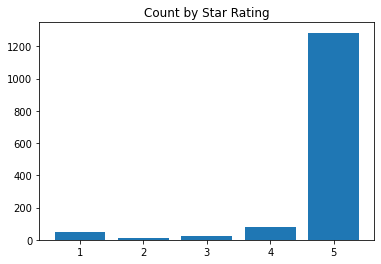

In [0]:
# Show the frequency of the 'star_rating' column.
star_counts_df = sdf.groupby('star_rating').count().sort('star_rating').toPandas()
# Set up a figure.
fig = plt.figure(facecolor='white')
# Bar plot of star_rating and count.
plt.bar(star_counts_df['star_rating'],star_counts_df['count'])
# fig.tight_layout()
plt.title("Count by Star Rating")
plt.savefig("frequency_star_rating_matplotlib.png")

In [0]:
# Create a buffer to hold the figure.
img_data = io.BytesIO()
# Write the Matplotlib figure to the buffer.
fig.savefig(img_data, format='png', bbox_inches='tight')
# Rewind the pointer to the start of the data.
img_data.seek(0)
# Connect to the s3fs file system.
s3 = s3fs.S3FileSystem(anon=False)

with s3.open('s3://my-bigdata-project-sf/models/frequency_star_rating_matplotlib.png', 'wb') as f:
    f.write(img_data.getbuffer())

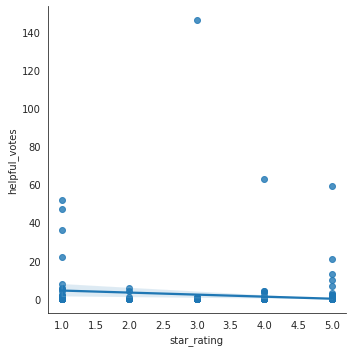

In [0]:
# Take the star_rating and helpful_votes columns, and convert to a Pandas dataframe.
df = sdf.select('star_rating', 'helpful_votes').toPandas() 

# Set the style for Seaborn plots.
sns.set_style("white")

# Create the relationship plot.
relationship_plot = sns.lmplot(x='star_rating', y='helpful_votes', data=df)

In [0]:
# Create a buffer to hold the figure.
img_data = io.BytesIO()
# Write the figure to the buffer.
relationship_plot.savefig(img_data, format='png', bbox_inches='tight')
# Rewind the pointer to the start of the data.
img_data.seek(0)
# Connect to the s3fs file system.
s3 = s3fs.S3FileSystem(anon=False)

with s3.open('s3://my-bigdata-project-sf/models/star_rating_helpful_votes_relationship_seaborn.png', 'wb') as f:
    f.write(img_data.getbuffer())

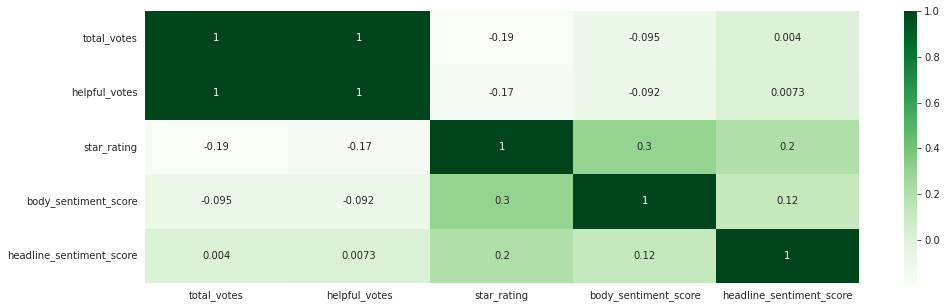

In [0]:
# Convert the numeric values to vector columns.
vector_column = "correlation_features"
# Choose the numeric (Double) columns.
numeric_columns = ['total_votes', 'helpful_votes', 'star_rating', 'body_sentiment_score', 'headline_sentiment_score']
assembler = VectorAssembler(inputCols=numeric_columns, outputCol=vector_column)
sdf_vector = assembler.transform(sdf).select(vector_column)

# Create the correlation matrix, then get just the values and convert to a list.
matrix = Correlation.corr(sdf_vector, vector_column).collect()[0][0]
correlation_matrix = matrix.toArray().tolist() 
# Convert the correlation to a Pandas dataframe.
correlation_matrix_df = pd.DataFrame(data=correlation_matrix, columns=numeric_columns, index=numeric_columns) 
plt.figure(figsize=(16,5))  

# Set the style for Seaborn plots.
sns.set_style("white")

sns.heatmap(correlation_matrix_df, 
            xticklabels=correlation_matrix_df.columns.values,
            yticklabels=correlation_matrix_df.columns.values,  cmap="Greens", annot=True)

plt.savefig("correlation_matrix.png")

In [0]:
# Create a buffer to hold the figure. 
img_data = io.BytesIO() 
# Write the figure to the buffer. 
plt.savefig(img_data, format='png', bbox_inches='tight') 
# Rewind the pointer to the start of the data. 
img_data.seek(0) 
# Connect to the s3fs file system. 
s3 = s3fs.S3FileSystem(anon=False)  

with s3.open('s3://my-bigdata-project-sf/models/correlation_matrix.png', 'wb') as f:
    f.write(img_data.getbuffer())

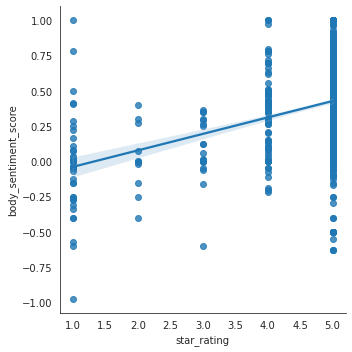

In [0]:
# Take the star_rating and body_sentiment_score columns, and convert to a Pandas dataframe.
df = sdf.select('star_rating', 'body_sentiment_score').toPandas() 

# Set the style for Seaborn plots.
sns.set_style("white")

# Create the relationship plot.
body_sentiment_plot = sns.lmplot(x='star_rating', y='body_sentiment_score', data=df)

In [0]:
# Create a buffer to hold the figure.
img_data = io.BytesIO()
# Write the figure to the buffer.
body_sentiment_plot.savefig(img_data, format='png', bbox_inches='tight')
# Rewind the pointer to the start of the data.
img_data.seek(0)
# Connect to the s3fs file system.
s3 = s3fs.S3FileSystem(anon=False)

with s3.open('s3://my-bigdata-project-sf/models/star_rating_body_sentiment_seaborn.png', 'wb') as f:
    f.write(img_data.getbuffer())

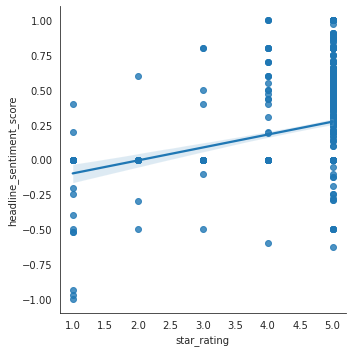

In [0]:
# Take the star_rating and headline_sentiment_score columns, and convert to a Pandas dataframe.
df = sdf.select('star_rating', 'headline_sentiment_score').toPandas() 

# Set the style for Seaborn plots.
sns.set_style("white")

# Create the relationship plot.
headline_sentiment_plot = sns.lmplot(x='star_rating', y='headline_sentiment_score', data=df)

In [0]:
# Create a buffer to hold the figure.
img_data = io.BytesIO()
# Write the figure to the buffer.
headline_sentiment_plot.savefig(img_data, format='png', bbox_inches='tight')
# Rewind the pointer to the start of the data.
img_data.seek(0)
# Connect to the s3fs file system.
s3 = s3fs.S3FileSystem(anon=False)

with s3.open('s3://my-bigdata-project-sf/models/star_rating_headline_sentiment_seaborn.png', 'wb') as f:
    f.write(img_data.getbuffer())

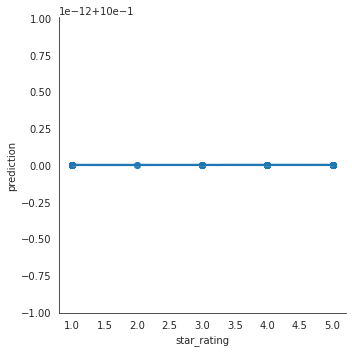

In [0]:
# Visualize regression results.
# Plot star_rating against predicted star_rating.
# Select and convert to a Pandas dataframe.
df = test_results.select('star_rating','prediction').toPandas()

# Set the style for Seaborn plots.
sns.set_style("white")

# Create a relationship plot between tip and prediction.
prediction_plot = sns.lmplot(x='star_rating', y='prediction', data=df)

In [0]:
# Create a buffer to hold the figure.
img_data = io.BytesIO()
# Write the figure to the buffer.
prediction_plot.savefig(img_data, format='png', bbox_inches='tight')
# Rewind the pointer to the start of the data.
img_data.seek(0)
# Connect to the s3fs file system.
s3 = s3fs.S3FileSystem(anon=False)

with s3.open('s3://my-bigdata-project-sf/models/star_rating_prediction_plot_seaborn.png', 'wb') as f:
    f.write(img_data.getbuffer())

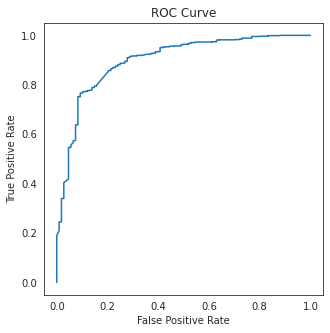

In [0]:
#Use bestModel to make an ROC curve.
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot(bestModel.summary.roc.select('FPR').collect(),
         bestModel.summary.roc.select('TPR').collect())
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.savefig("roc1.png")
plt.show()

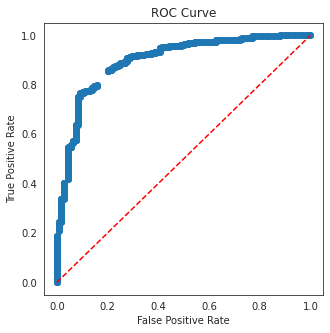

In [0]:
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
x = bestModel.summary.roc.select('FPR').collect() 
y = bestModel.summary.roc.select('TPR').collect() 
plt.scatter(x, y)
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title("ROC Curve") 
plt.savefig("reviews_roc.png")

In [0]:
# Create a buffer to hold the figure.
img_data = io.BytesIO() 
# Write the figure to the buffer. 
plt.savefig(img_data, format='png', bbox_inches='tight') 
# Rewind the pointer to the start of the data. 
img_data.seek(0) 
# Connect to the s3fs file system. 
s3 = s3fs.S3FileSystem(anon=False)  

with s3.open('s3://my-bigdata-project-sf/models/ROC_curve.png', 'wb') as f:
    f.write(img_data.getbuffer())